In [153]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
from navigation_game import NavigableNetwork
import scipy
import seaborn as sns
import numpy as np

In [157]:
# Create test coordinates matching the paper's example
coords = np.array([
    [1, 1],  # A
    [3, 1],  # B
    [3, 2],  # C
    [1, 5],  # D
])

# Create network and get equilibrium
net = NavigableNetwork(coords)
equilibrium = net.build_nash_equilibrium()

# Print the adjacency matrix
print("Adjacency matrix:")
print(equilibrium.astype(int))

# Check navigability
is_navigable = net.verify_navigability(equilibrium)
print("Is navigable:", is_navigable)


Adjacency matrix:
[[0 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]
Is navigable: True


<Axes: >

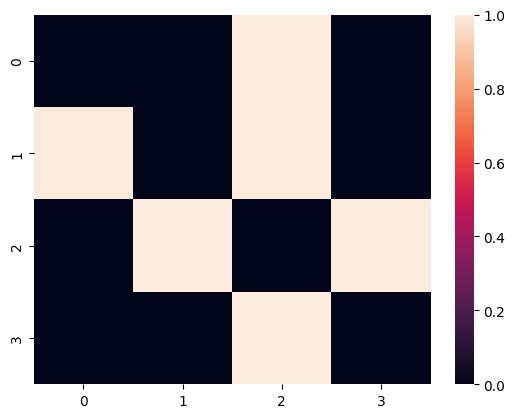

In [150]:
sns.heatmap(equilibrium)

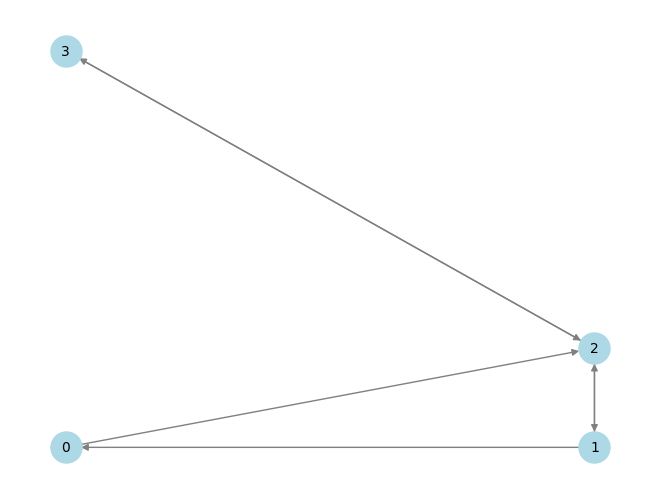

In [161]:
import networkx as nx

G = nx.from_numpy_array(equilibrium, create_using=nx.DiGraph)

# Extract positions of nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, pos = coords, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')

In [151]:
res_parcellation = 0
consensus_mat = scipy.io.loadmat(
    "datasets/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]


In [152]:
game = NavigableNetwork(coordinates)
nash_network = game.build_nash_equilibrium()


Distance comparisons for node A:

Comparing for potential next hop v=1:
  w=1: d(1,w)=0.00 < d(A,w)=18.74
  -> 1 helps A reach 1
  w=4: d(1,w)=15.47 < d(A,w)=26.41
  -> 1 helps A reach 4
  w=5: d(1,w)=33.02 < d(A,w)=37.70
  -> 1 helps A reach 5
  w=6: d(1,w)=25.81 < d(A,w)=30.77
  -> 1 helps A reach 6
  w=8: d(1,w)=56.69 < d(A,w)=57.87
  -> 1 helps A reach 8
  w=16: d(1,w)=80.84 < d(A,w)=80.85
  -> 1 helps A reach 16
  w=31: d(1,w)=50.30 < d(A,w)=50.92
  -> 1 helps A reach 31

Comparing for potential next hop v=2:
  w=2: d(2,w)=0.00 < d(A,w)=32.80
  -> 2 helps A reach 2
  w=35: d(2,w)=53.82 < d(A,w)=60.04
  -> 2 helps A reach 35
  w=36: d(2,w)=17.40 < d(A,w)=43.08
  -> 2 helps A reach 36
  w=37: d(2,w)=28.26 < d(A,w)=29.37
  -> 2 helps A reach 37
  w=38: d(2,w)=59.29 < d(A,w)=63.56
  -> 2 helps A reach 38
  w=40: d(2,w)=47.66 < d(A,w)=57.73
  -> 2 helps A reach 40

Comparing for potential next hop v=3:
  w=2: d(3,w)=22.90 < d(A,w)=32.80
  -> 3 helps A reach 2
  w=3: d(3,w)=0.00 < d(A,

<Axes: >

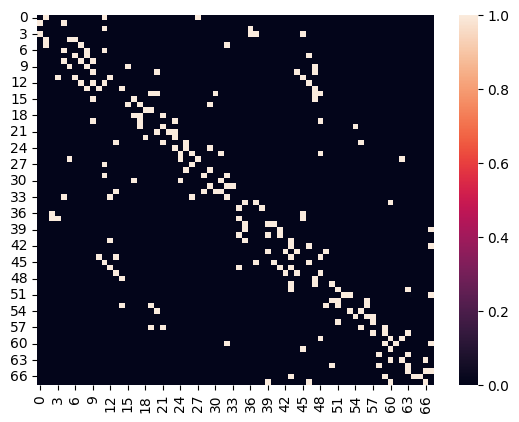

In [81]:
sns.heatmap(nash_network.astype(int))

In [82]:
game.verify_navigability(nash_network, verbose=True)

Routing failed from node 0 to 51: Next node 14 is not closer to target.
Failed to route from 0 to 51.


False

In [11]:
game.verify_cost_optimization(nash_network)

True

In [12]:
game.verify_unilateral_improvement(nash_network)

True

<Axes: >

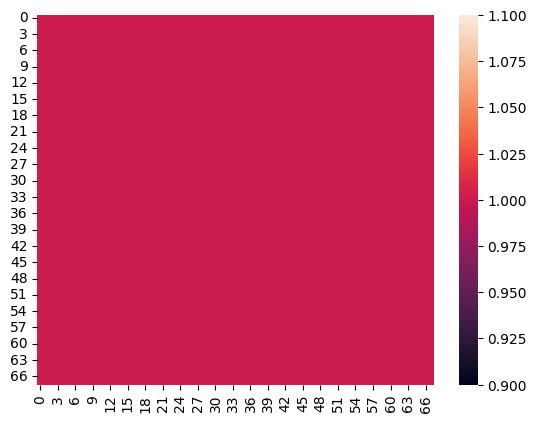

In [10]:
sns.heatmap(scipy.linalg.expm(nash_network).astype(bool))

In [ ]:
game.verify_navigability(nash_network, using_communicability=True)

1.0

In [ ]:
test = nash_network

In [7]:
import numpy as np

In [139]:
r = 2.0  # radius
angles = np.linspace(0, 2*np.pi, 5, endpoint=False)
coords = np.zeros((5, 2))
# Center node at origin
coords[0] = [0, 0]
# Surrounding nodes
for i in range(4):
    coords[i+1] = [r * np.cos(angles[i]), r * np.sin(angles[i])]

network = NavigableNetwork(coords)
nash = network.build_nash_equilibrium()

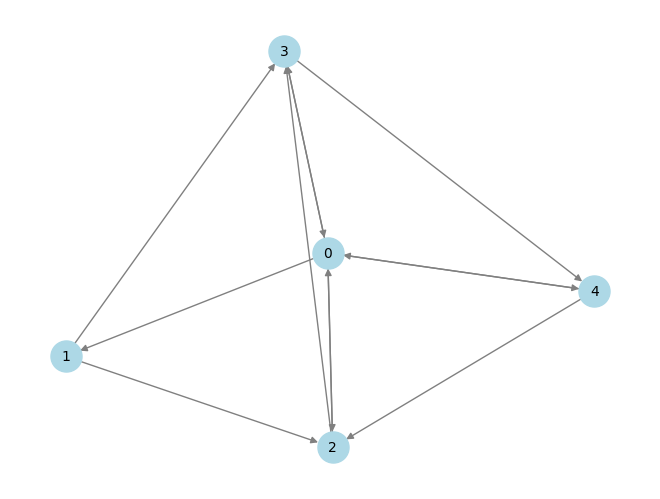

In [141]:
import networkx as nx

G = nx.from_numpy_array(nash, create_using=nx.DiGraph)
# Add nodes with positions
for i, (x, y) in enumerate(coords):
    G.add_node(i, pos=(x, y))

# Add edges (example: connecting each node to the next)
for i in range(len(coords) - 1):
    G.add_edge(i, i + 1)

# Extract positions of nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')

<Axes: >

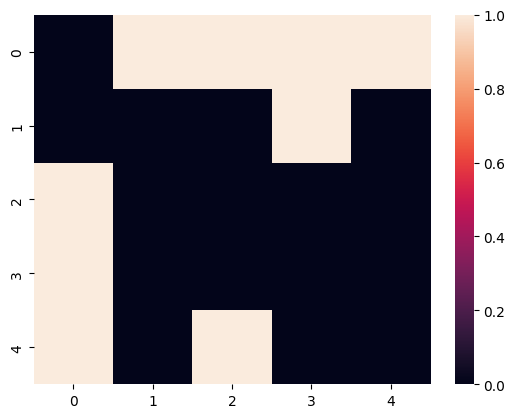

In [133]:
sns.heatmap(nash)

<Axes: >

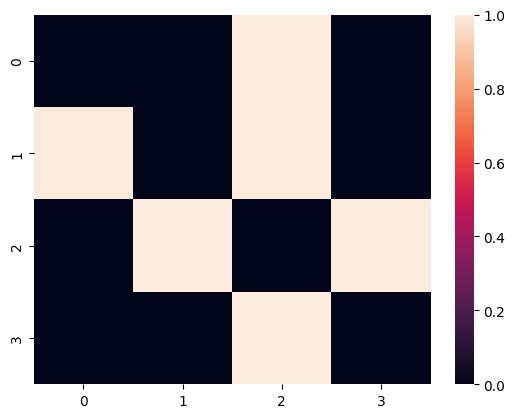

In [61]:
coords = np.array([
    [1, 1],
    [3, 1],
    [3, 2],
    [1, 5],
])

network = NavigableNetwork(coords)
nash = network.build_nash_equilibrium()
sns.heatmap(nash)

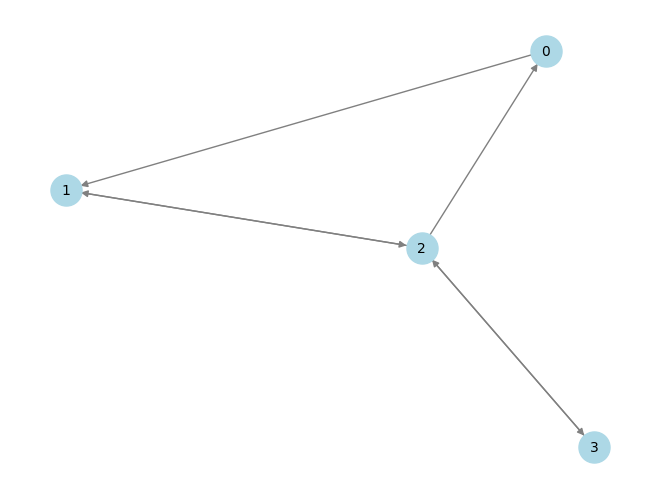

In [64]:
import networkx as nx

G = nx.from_numpy_array(nash.T, create_using=nx.DiGraph)
# Add nodes with positions
for i, (x, y) in enumerate(coords[::-1]):
    G.add_node(i, pos=(x, y))

# Add edges (example: connecting each node to the next)
for i in range(len(coords) - 1):
    G.add_edge(i, i + 1)

# Extract positions of nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')


In [74]:
coords = np.array([
    [0, 1],
    [-1, 0],
    [1, 0]
])

network = NavigableNetwork(coords)
adjacency = network.build_nash_equilibrium(symmetry='forced')

# Expected symmetric adjacency matrix
expected = np.array([
    [False, True,  True ],
    [True,  False, True ],
    [True,  True,  False]
])

<Axes: >

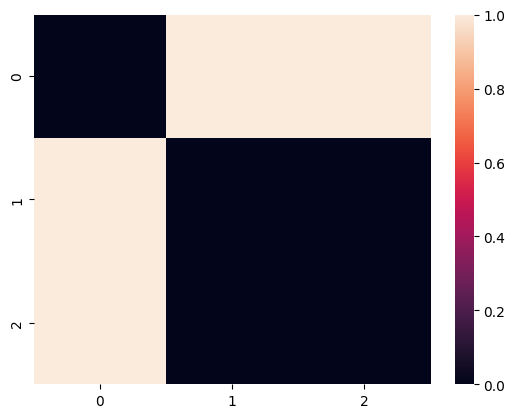

In [77]:
sns.heatmap(adjacency)

<Axes: >

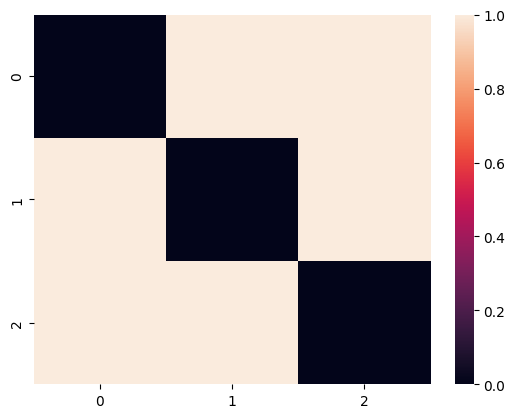

In [79]:
sns.heatmap(expected)

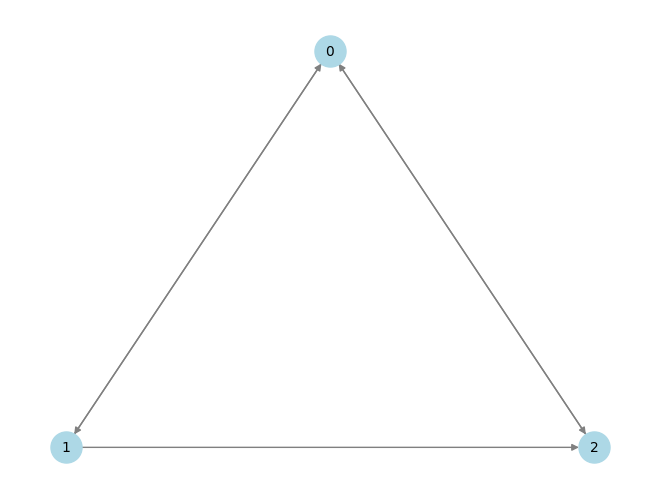

In [80]:
G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph)
# Add nodes with positions
for i, (x, y) in enumerate(coords):
    G.add_node(i, pos=(x, y))

# Add edges (example: connecting each node to the next)
for i in range(len(coords) - 1):
    G.add_edge(i, i + 1)

# Extract positions of nodes
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos=pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')


In [65]:
# Create test coordinates matching the paper's example
coords = np.array([
    [1, 1],  # A
    [3, 1],  # B
    [3, 2],  # C
    [1, 5],  # D
])

# Create network and get equilibrium
net = NavigableNetwork(coords)
equilibrium = net.build_nash_equilibrium()

# Print the adjacency matrix
print("Adjacency matrix:")
print(equilibrium.astype(int))

# Verify if it's a valid Nash equilibrium
is_nash = net.verify_nash_equilibrium(equilibrium)
print("\nIs Nash equilibrium:", is_nash)

# Check navigability
is_navigable = net.verify_navigability(equilibrium)
print("Is navigable:", is_navigable)

Adjacency matrix:
[[0 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]

Is Nash equilibrium: True
Is navigable: True
